In [1]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [2]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pandas as pd


# Încărcarea etichetelor claselor din datele NSL-KDD
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Încărcăm datele pentru a obține etichetele claselor
data_path = "../Data/nsl-kdd/KDDTrain+.txt"  # Schimbă calea dacă e necesar
df = pd.read_csv(data_path, delimiter=',', header=None)
df.columns = columns

# Creăm și antrenăm un encoder pentru etichetele claselor
label_encoder_y = LabelEncoder()
y_raw = df['attack']
y_encoded = label_encoder_y.fit_transform(y_raw)

# Afișăm clasele disponibile
all_classes = label_encoder_y.classes_
print("\nClasele modelului:")
for i, class_name in enumerate(all_classes):
    print(f"{i}: {class_name}")



Clasele modelului:
0: back
1: buffer_overflow
2: ftp_write
3: guess_passwd
4: imap
5: ipsweep
6: land
7: loadmodule
8: multihop
9: neptune
10: nmap
11: normal
12: perl
13: phf
14: pod
15: portsweep
16: rootkit
17: satan
18: smurf
19: spy
20: teardrop
21: warezclient
22: warezmaster


In [3]:
print(df.shape)

(125973, 43)


In [4]:
# Afișează numărul total de exemple din setul de date
num_samples = df.shape[0]
num_features = df.shape[1] - 2  # Excludem coloanele 'attack' și 'level'
print(f"\nSetul de date conține {num_samples} exemple și {num_features} caracteristici de intrare.")



Setul de date conține 125973 exemple și 41 caracteristici de intrare.


In [5]:
print("\nDistribuția claselor în setul de date:")
print(df['attack'].value_counts())



Distribuția claselor în setul de date:
attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


In [6]:
import os
import tkinter as tk
from tkinter import scrolledtext
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Definirea coloanelor
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

In [7]:
MODEL_DIR = os.path.join(".", "test_model")
MODEL_FILE_PATH = os.path.join(MODEL_DIR, "model_traffic_test_2025_05_07.h5")

In [8]:
print(df['attack'])

0          normal
1          normal
2         neptune
3          normal
4          normal
           ...   
125968    neptune
125969     normal
125970     normal
125971    neptune
125972     normal
Name: attack, Length: 125973, dtype: object


In [9]:
# Funcție de încărcare și preprocesare a datelor NSL-KDD
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns  # Setează numele coloanelor
    
    X = df.iloc[:, :-1]  # Toate coloanele, mai puțin ultima
    y_raw = df['attack']  # Ultima coloană este eticheta
    
    # Convertim coloanele categorice
    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le
    
    # Convertim etichetele de ieșire
    label_encoder_y = LabelEncoder()
    y = label_encoder_y.fit_transform(y_raw)
    
    # Scala datele
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    
    return X_scaled, y, label_encoder_y

In [10]:
X, y, label_encoder_y = load_and_preprocess_data("../Data/nsl-kdd/KDDTrain+.txt")
num_classes = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y) # stratify = y - pentru sa am prezente toate clasele in ambele seturi test/train

In [11]:
num_classes = len(np.unique(y))
print(num_classes)

23


In [12]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Convolution1D(128, 3, padding="same", activation="relu", input_shape=input_shape),
        Convolution1D(128, 3, padding="same", activation="relu"),
        Convolution1D(128, 3, padding="same", activation="relu"),
        MaxPooling1D(pool_size=2),
        LSTM(30),
        Dropout(0.1),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    return model

In [13]:
os.makedirs(MODEL_DIR, exist_ok=True)
model = create_cnn_lstm_model(X_train.shape[1:], num_classes)

c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
print("Clase unice în y_test:", np.unique(y_test))
print("Toate clasele din encoder:", label_encoder_y.classes_)


Clase unice în y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Toate clasele din encoder: ['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Presupunând că X_train, y_train, X_test, y_test, model și label_encoder_y au fost deja definite

# 1. Antrenăm modelul pe mai multe epoci pentru a avea un istoric de training semnificativ
# (dacă modelul este deja antrenat și salvat, puteți sări peste acest pas sau să reantrenați modelul)
EPOCHS = 100  # Alegeți un număr adecvat de epoci
BATCH_SIZE = 64

# Definim callback-ul pentru early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Antrenăm modelul cu early stopping
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Salvăm modelul
model.save(MODEL_FILE_PATH)
print("Modelul a fost antrenat și salvat în format .h5.")


Epoch 1/100
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8320 - loss: 0.6905 - val_accuracy: 0.9657 - val_loss: 0.1354
Epoch 2/100
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9694 - loss: 0.1199 - val_accuracy: 0.9917 - val_loss: 0.0560
Epoch 3/100
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9861 - loss: 0.0594 - val_accuracy: 0.9961 - val_loss: 0.0268
Epoch 4/100
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9931 - loss: 0.0332 - val_accuracy: 0.9976 - val_loss: 0.0167
Epoch 5/100
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9945 - loss: 0.0245 - val_accuracy: 0.9972 - val_loss: 0.0129
Epoch 6/100
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9959 - loss: 0.0194 - val_accuracy: 0.9937 - val_loss: 0.0170
Epoch 7/100
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9960 - loss: 0.0150 - val_accuracy: 0.9984 - val_loss: 0.0073
Epoch 8/100
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9976

Modelul a fost antrenat și salvat în format .h5.


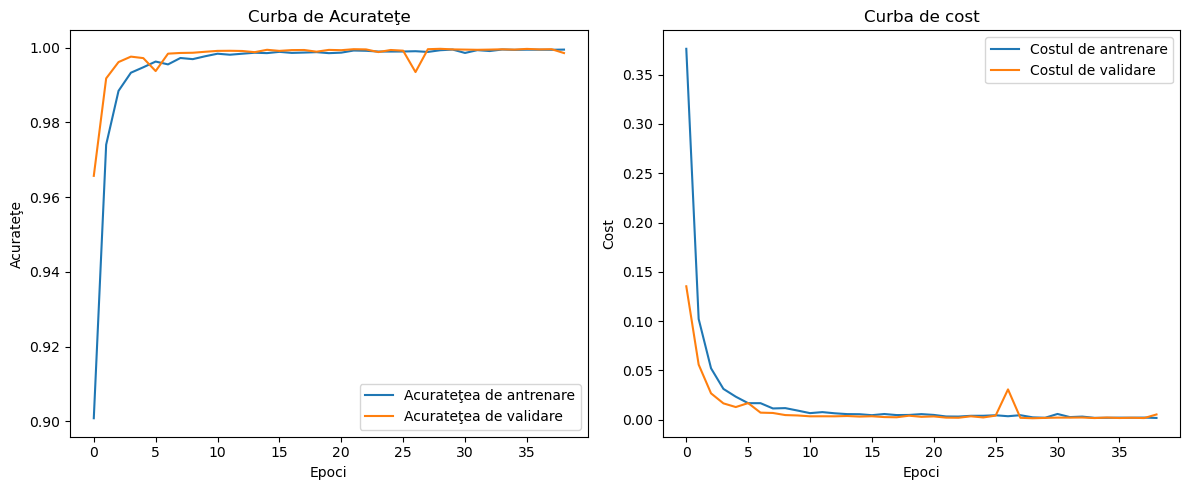

1181/1181 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Matricea de Confuzie:
[[  287     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     9     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0    15     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     3     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0  1080     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     5     0     0     0     0     0
   

c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [16]:
# 2. Afișăm curbele de Accuracy și Loss
plt.figure(figsize=(12, 5))

# Curba de Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurateţea de antrenare')
plt.plot(history.history['val_accuracy'], label='Acurateţea de validare')
plt.title('Curba de Acurateţe')
plt.xlabel('Epoci')
plt.ylabel('Acurateţe')
plt.legend()

# Curba de Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Costul de antrenare')
plt.plot(history.history['val_loss'], label='Costul de validare')
plt.title('Curba de cost')
plt.xlabel('Epoci')
plt.ylabel('Cost')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Evaluarea performanței pe setul de test
# Obținem predicțiile modelului
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculăm matricea de confuzie
cm = confusion_matrix(y_test, y_pred)
print("Matricea de Confuzie:")
print(cm)

# Calculăm raportul de clasificare (precision, recall, F1-score)
report = classification_report(y_test, y_pred)
print("Raportul de Clasificare:")
print(report)

# Calculăm acuratețea generală
acc = accuracy_score(y_test, y_pred)
print("Acuratețea Generală: {:.2f}%".format(acc * 100))


In [17]:
print("Clase unice în y_test:", np.unique(y_test))
print("Clase unice în y_pred:",np.unique(y_pred))
print("Toate clasele din encoder:", label_encoder_y.classes_)

Clase unice în y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Clase unice în y_pred: [ 0  1  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 20 21 22]
Toate clasele din encoder: ['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


Matricea de Confuzie:
[[  287     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     9     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0    15     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     3     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0  1080     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     5     0     0     0     0     0
      0     0     0     0     0     0     0   

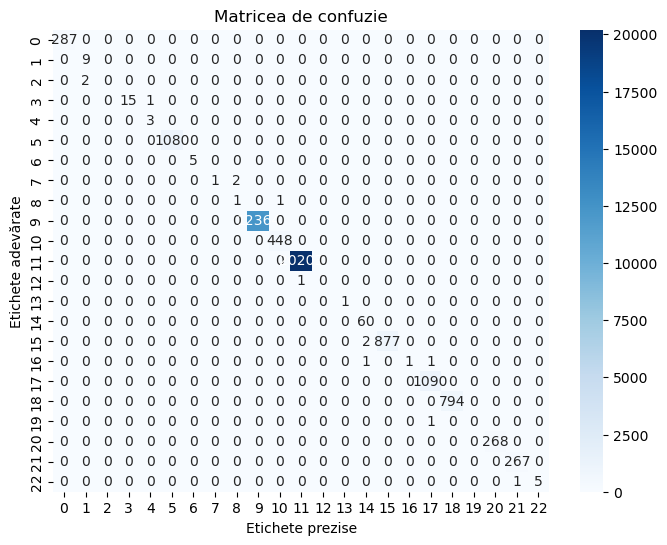

Acuratețea Generală: 99.97%


In [18]:
import seaborn as sns

# Calculăm matricea de confuzie
cm = confusion_matrix(y_test, y_pred)
print("Matricea de Confuzie:")
print(cm)

# Afișăm matricea de confuzie colorată
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Etichete prezise")
plt.ylabel("Etichete adevărate")
plt.title("Matricea de confuzie")
plt.show()

# Calculăm acuratețea generală
acc = accuracy_score(y_test, y_pred)
print("Acuratețea Generală: {:.2f}%".format(acc * 100))


In [19]:
print("Clase unice în y_test:", np.unique(y_test))
print("Clasele originale din encoder:", label_encoder_y.classes_)


Clase unice în y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Clasele originale din encoder: ['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Matricea de Confuzie:
[[  287     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     9     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0    15     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     3     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0  1080     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     5     0     0     0     0     0
   

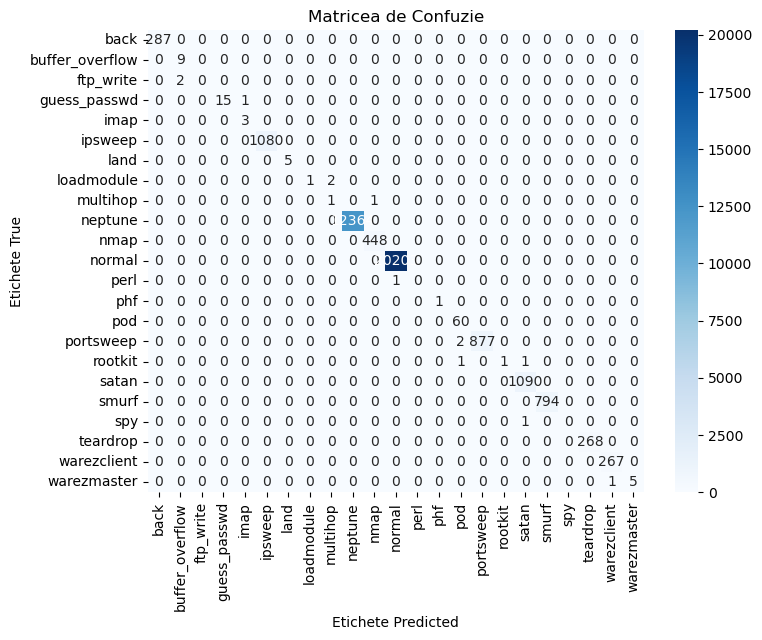

Raportul de Clasificare:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       287
           1       0.82      1.00      0.90         9
           2       0.00      0.00      0.00         2
           3       1.00      0.94      0.97        16
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00      1080
           6       1.00      1.00      1.00         5
           7       1.00      0.33      0.50         3
           8       0.33      0.50      0.40         2
           9       1.00      1.00      1.00     12364
          10       1.00      1.00      1.00       448
          11       1.00      1.00      1.00     20203
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       0.95      1.00      0.98        60
          15       1.00      1.00      1.00       879
          16       1.00      0.33      0.50         3
  

c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Presupunând că X_train, y_train, X_test, y_test și model sunt deja definite.
# Exemplu de evaluare și afișare a matricei de confuzie

# Obținem predicțiile modelului
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculăm matricea de confuzie
cm = confusion_matrix(y_test, y_pred)
print("Matricea de Confuzie:")
print(cm)

# Încărcarea etichetelor claselor din datele NSL-KDD
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

data_path = "../Data/nsl-kdd/KDDTrain+.txt"  # Actualizează calea dacă este necesar
df = pd.read_csv(data_path, delimiter=',', header=None)
df.columns = columns

# Construim encoder-ul pentru etichete
label_encoder_y = LabelEncoder()
y_raw = df['attack']
y_encoded = label_encoder_y.fit_transform(y_raw)
all_classes = label_encoder_y.classes_

# Afișăm matricea de confuzie colorată cu numele etichetelor pe axe
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_classes, yticklabels=all_classes, cbar=True)
plt.xlabel("Etichete Predicted")
plt.ylabel("Etichete True")
plt.title("Matricea de Confuzie")
plt.show()

# Afișăm raportul de clasificare și acuratețea generală
report = classification_report(y_test, y_pred)
print("Raportul de Clasificare:")
print(report)

acc = accuracy_score(y_test, y_pred)
print("Acuratețea Generală: {:.2f}%".format(acc * 100))

# Afișăm numele fiecărei etichete
print("\nClasele modelului:")
for i, class_name in enumerate(all_classes):
    print(f"{i}: {class_name}")


# Vreau să îmbunătățesc rețeaua